# **Variational Auto Encoders**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random

In [2]:
# Use randomseed for more consistent results
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)
print(x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


<h2>Available Labels/Classes in Fashion Mnist dataset</h2>

<table align="left">
<thead>
<tr>
<th align="center">Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td align="center">1</td>
<td>Trouser</td>
</tr>
<tr>
<td align="center">2</td>
<td>Pullover</td>
</tr>
<tr>
<td align="center">3</td>
<td>Dress</td>
</tr>
<tr>
<td align="center">4</td>
<td>Coat</td>
</tr>
<tr>
<td align="center">5</td>
<td>Sandal</td>
</tr>
<tr>
<td align="center">6</td>
<td>Shirt</td>
</tr>
<tr>
<td align="center">7</td>
<td>Sneaker</td>
</tr>
<tr>
<td align="center">8</td>
<td>Bag</td>
</tr>
<tr>
<td align="center">9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>

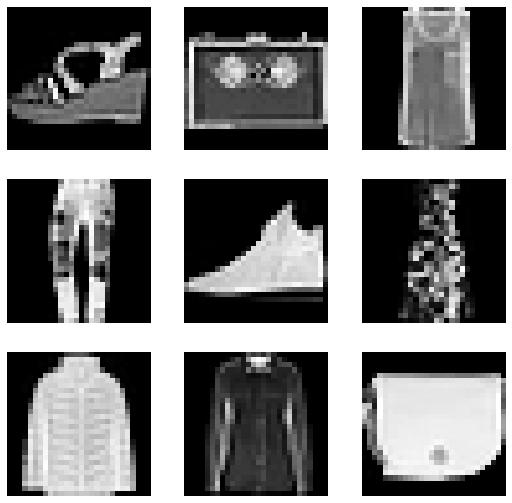

In [4]:
plt.figure(figsize=(9, 9))

# Choose 9 samples out of 60K available in the train set
rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show();

In [5]:
dataset = np.concatenate([x_train, x_test], axis=0)
# Converts images from 28x28 to 28x28x1 as convolutional layers expect 3 channels
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


# Create a sampling layer where we define reparameterization 
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [7]:
def buildEncoder(latentDim, encoderInputs):

  # Given a batch of images the convolutional block extracts the features
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  # pass the inputs through the convolutional block
  x = l1(encoderInputs)

  # a dedicated layer to learn mean in parallel
  zMean = layers.Dense(latentDim, name="z_mean")(x)

  # a dedicated layer to learn variance in parallel
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  # now the reparametrization trick to find z as defined by mean and variance
  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# trigger the function to actually build the model
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          878144      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential[0][0]']             
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential[0][0]']             
                                                                                            

In [8]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# build the actual model
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


## Loss Functions ##


In [9]:
# First loss function is the reconstruction loss, which penalizes images that are not similar to the original images.
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

In [10]:
# Kullback-Liebler Divergence loss function which penalizes the model if it learns 
# a probability distribution "z" that is different from the original probability distribution of the data "X".
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

In [11]:
# So now we'll combine these into the total loss function
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [12]:
# Since we are using a custom loss function on mu and sigma, we need to override how the loss is calculated. 
# We need to compare X_original and X_reconstructed at the same time while calculating the Kullback-Liebler (KL) loss.

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # register total loss as an observable metric in the model training history
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  # This are all observable metrics 
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # Now calculate loss + calculate gradients + update weights
  def train_step(self, data):
    # Gradient tape is a recording of all gradients for the trainable 
    # weights that need to be updated
    with tf.GradientTape() as tape:
        # forward path
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # backward path
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # keep track of loss
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # return the loss for history object
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

## Train the model ##

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 49s 62ms/step - total_loss: 313.8479 - ce_loss: 302.6221 - kl_loss: 3.7419
Epoch 2/32
547/547 [==============================] - 31s 56ms/step - total_loss: 278.2122 - ce_loss: 264.2872 - kl_loss: 4.6416
Epoch 3/32
547/547 [==============================] - 31s 56ms/step - total_loss: 275.2857 - ce_loss: 260.9625 - kl_loss: 4.7745
Epoch 4/32
547/547 [==============================] - 31s 57ms/step - total_loss: 273.7219 - ce_loss: 259.2007 - kl_loss: 4.8404
Epoch 5/32
547/547 [==============================] - 31s 57ms/step - total_loss: 272.7355 - ce_loss: 258.0924 - kl_loss: 4.8810
Epoch 6/32
547/547 [==============================] - 31s 57ms/step - total_loss: 271.7950 - ce_loss: 257.0639 - kl_loss: 4.9103
Epoch 7/32
547/547 [==============================] - 31s 57ms/step - total_loss: 271.2821 - ce_loss: 256.4409 - kl_loss: 4.9471
Epoch 8/32
547/547 [==============================] - 31s 57ms/step - total_loss: 270.6134 - ce_l

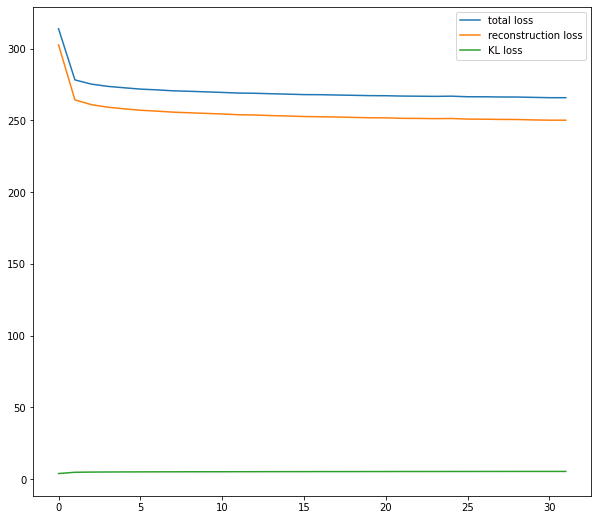

In [14]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

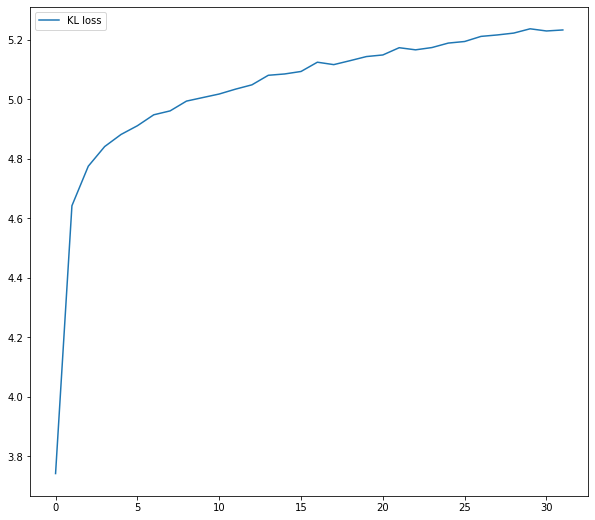

In [15]:
# Let's zoom into the KL loss so we can see it better
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

# Plot the results ##


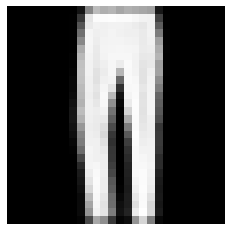

In [16]:
# use a mean (mu) of 1 and variance (sigma) of 2 (just a guess to start with)
synth = vae.decoder.predict([[1, 2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

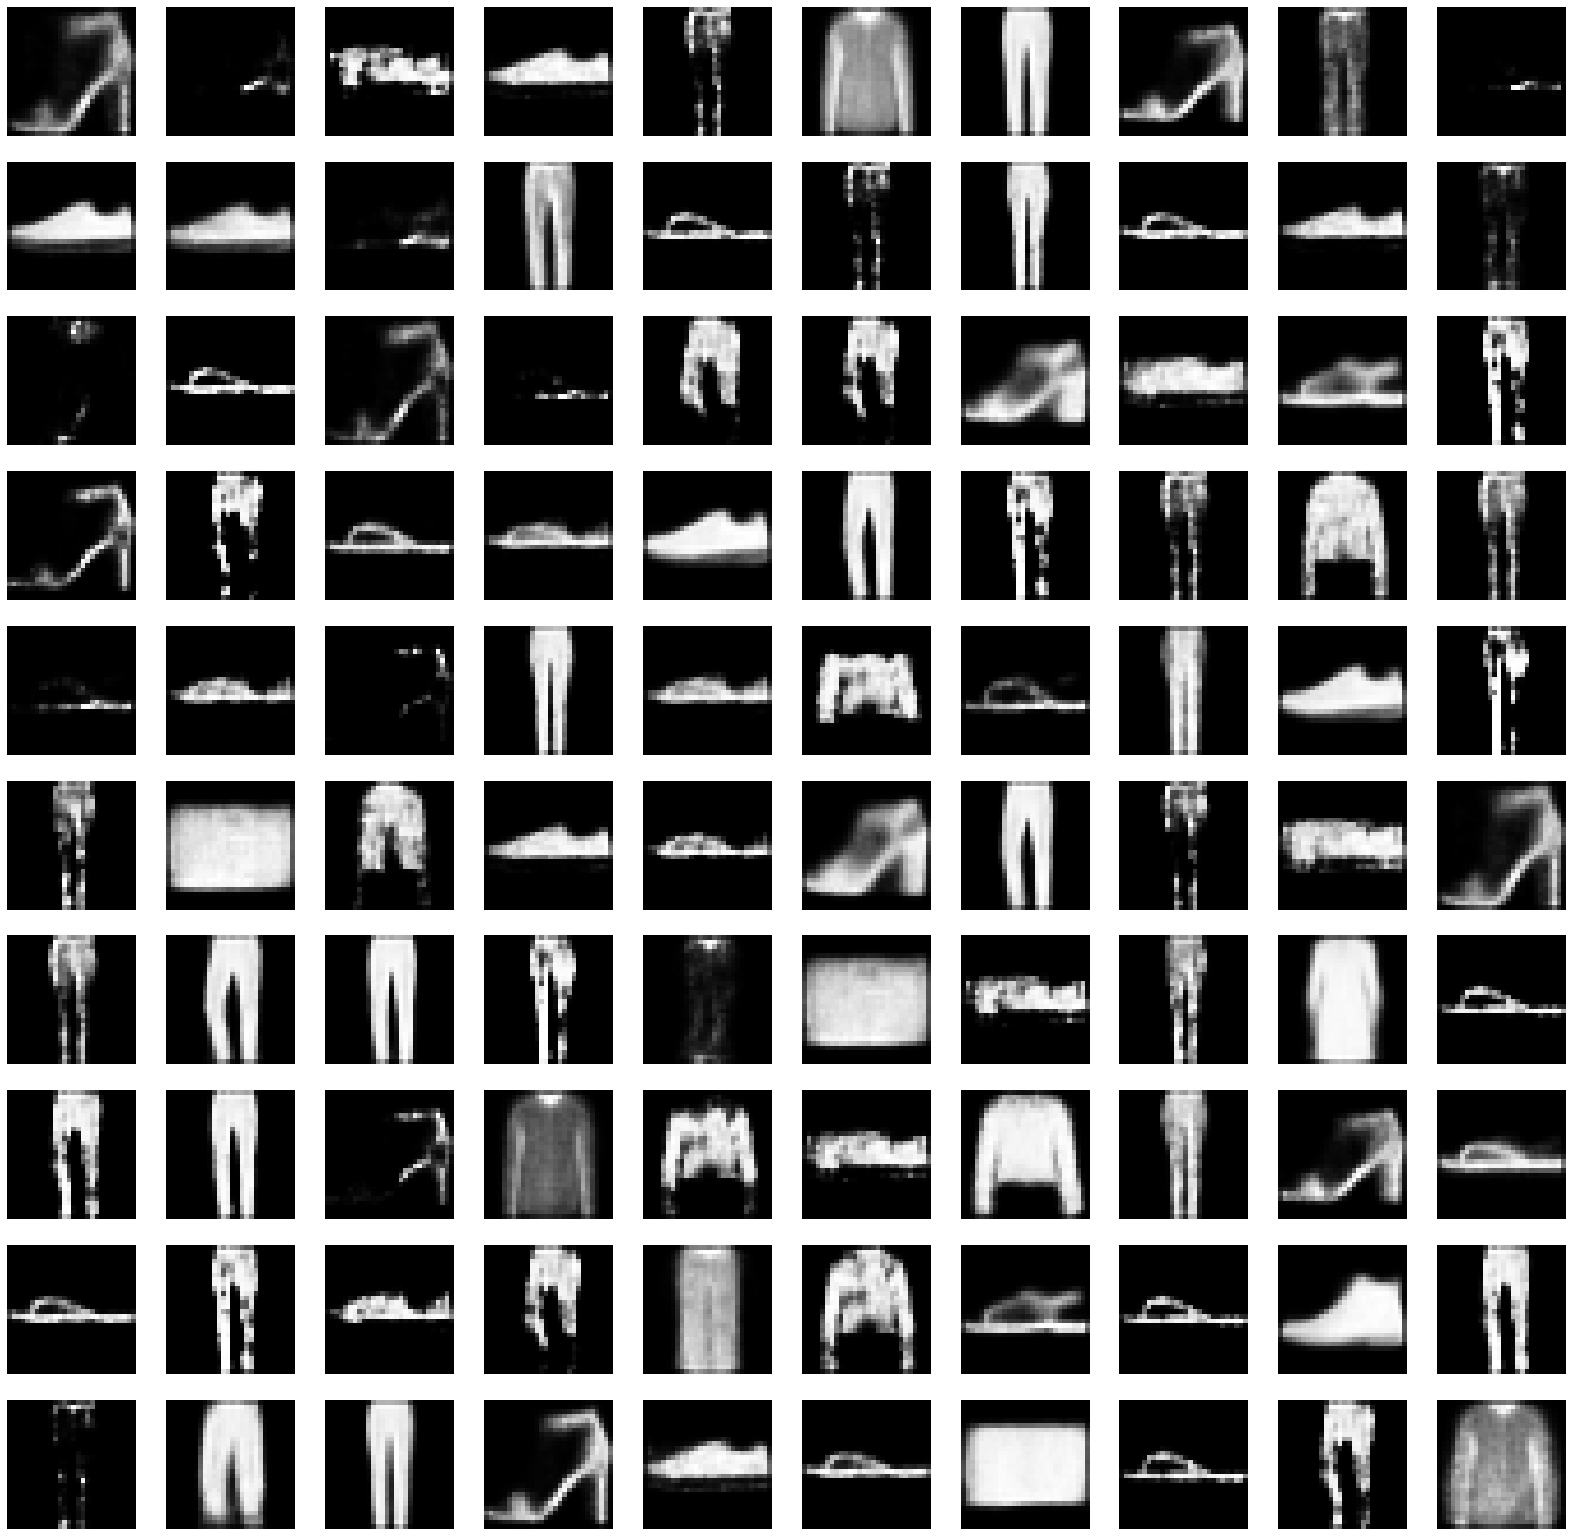

In [22]:
z = np.random.normal(loc=0, scale=4, size=(100,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

In [18]:
# Map an image from a category through the encoder and observe the output. 
# Then use those outputs to conditionally instruct the decoder to sample from a particular category.

idx = 1280 # arbitrarily
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)
# obtain z(mu,sigma) for the given image
_, _, z = vae.encoder.predict(batchOfImages)

# now reconstruct a similar image
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)


array([[-0.43368688,  1.3138627 ]], dtype=float32)

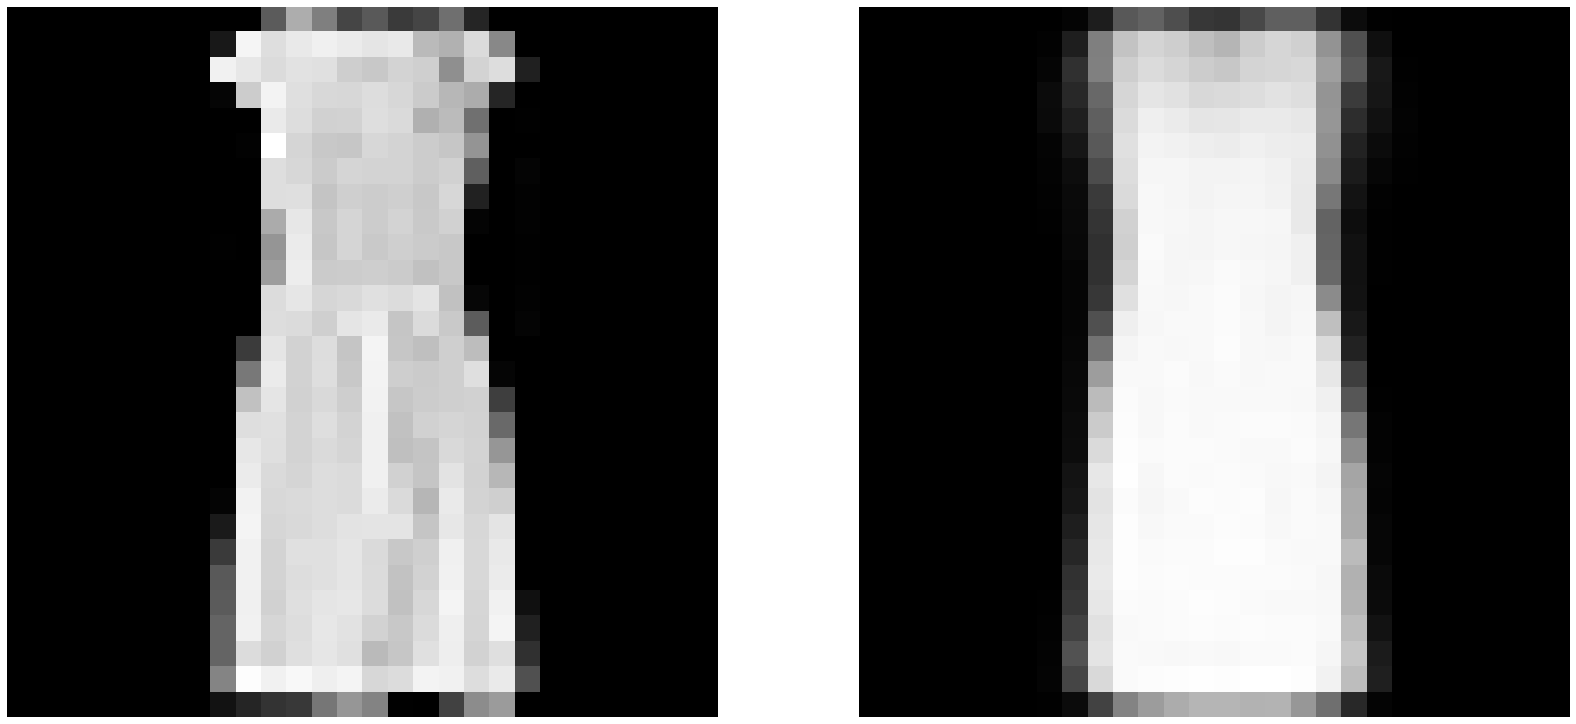

In [19]:
plt.figure(figsize=(28, 28))

# original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# reconstructed
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

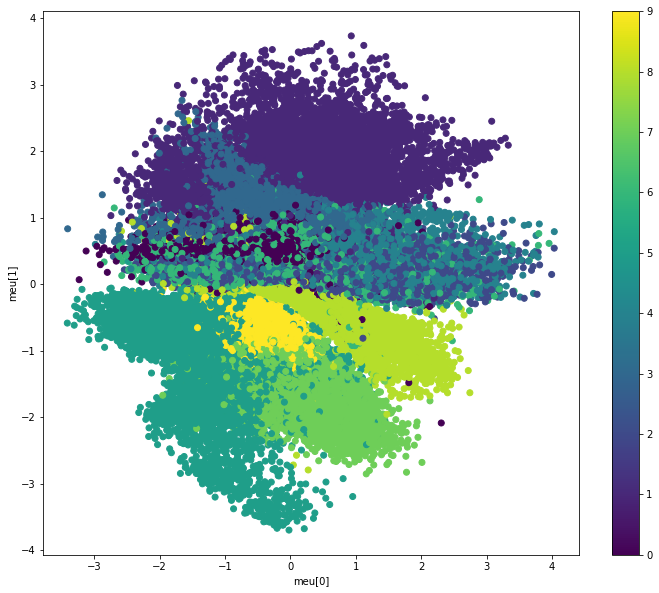

In [20]:
"""
VAE can be used in unsupervised learning of large text or unlabeled images corpus
to cluster the samples into categories
"""
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();